# Importing the required libraries and packages

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate, Concatenate
from keras.callbacks import ModelCheckpoint

from keras.datasets import cifar10

import tensorflow as tf

% matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(2017) 

# Loading the data 

In [4]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_test)

170500096/170498071 [==============================] - 13s 0us/step
10000


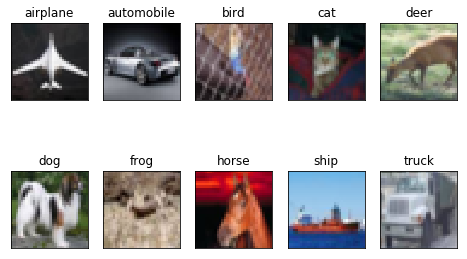

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,5))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)

plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model Architecture for ENAS

Here, I've changed the model from having Dense layers to the actual Convolution layers.

In [9]:
train_features.shape

(50000, 32, 32, 3)

In [0]:
def space_to_depth_x1(layer):
    return tf.space_to_depth(layer, 2)

def space_to_depth_x2(layer):
    return tf.space_to_depth(layer, 4)

In [11]:
input = Input(shape=(32,32,3))

layer1 = SeparableConv2D(64, (5,5), padding='same')(input)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)

skip_connection1 = layer1
skip1 = Lambda(space_to_depth_x1)(layer1)
skip11 = Lambda(space_to_depth_x2)(layer1)


layer2 = Conv2D(64, (5,5), padding='same')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

skip_connection2 = layer2
skip2 = Lambda(space_to_depth_x1)(layer2)
skip22 = Lambda(space_to_depth_x2)(layer2)


layer3 = Conv2D(64, (5,5), padding='same')(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)

skip_connection3 = layer3
skip3 = Lambda(space_to_depth_x1)(layer3)
skip33 = Lambda(space_to_depth_x2)(layer3)

concat1 = Concatenate()([skip_connection1, layer3])

layer4 = SeparableConv2D(64, (5,5), padding='same')(concat1)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

skip_connection4 = layer4
skip4 = Lambda(space_to_depth_x1)(layer4)
skip44 = Lambda(space_to_depth_x2)(layer4)

concat2 = Concatenate()([layer4, skip_connection1])

bottleneck1 = Conv2D(64, (1,1), padding='same')(concat2)
max_pool1 = MaxPooling2D(pool_size=(2,2))(bottleneck1)

layer5 = SeparableConv2D(128, (3,3), padding='same')(max_pool1)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)

skip_connection5 = layer5
skip5 = Lambda(space_to_depth_x1)(layer5)

concat3 = Concatenate()([layer5, skip1, skip4])

layer6 = Conv2D(128, (5,5), padding='same')(concat3)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

skip_connection6 = layer6
skip6 = Lambda(space_to_depth_x1)(layer6)

concat4 = Concatenate()([layer6, skip_connection5, skip4, skip3])

layer7 = SeparableConv2D(128, (3,3), padding='same')(concat4)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

skip_connection7 = layer7
skip7 = Lambda(space_to_depth_x1)(layer7)

concat5 = Concatenate()([layer7, skip_connection6, skip_connection5, skip4, skip3, skip1])

layer8 = SeparableConv2D(128, (5,5), padding='same')(concat5)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

concat6 = Concatenate()([layer8, skip_connection7, skip_connection5, skip4, skip1])

bottleneck2 = Conv2D(64, (1,1), padding='same')(concat6)
max_pool2 = MaxPooling2D(pool_size=(2,2))(bottleneck2)

concat7 = concatenate([max_pool2, skip6])

layer9 = Conv2D(256, (5,5), padding='same')(concat7)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

skip_connection9 = layer9

concat8 = Concatenate()([layer9, skip7, skip22, skip11])

layer10 = SeparableConv2D(256, (5,5), padding='same')(concat8)
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)

skip_connection10 = layer10

concat9 = Concatenate()([layer10, skip_connection9, skip5, skip33, skip22])

layer11 = Conv2D(256, (5,5), padding='same')(concat9)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

concat10 = Concatenate()([layer11, skip_connection10, skip7, skip5, skip44, skip33, skip11])

layer12 = SeparableConv2D(256, (5,5), padding='same')(concat10)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

concat11 = Concatenate()([layer12, skip_connection10, skip7, skip44])

layer13 = Conv2D(10, (1,1), padding='same')(concat11)
layer13 = GlobalAveragePooling2D()(layer13)

output = Activation('softmax')(layer13)

W0615 13:08:28.298961 140080530950016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 13:08:28.336402 140080530950016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 13:08:28.346254 140080530950016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 13:08:28.397378 140080530950016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 13:08:28.398416 1400805309

In [12]:
model = Model(input=[input], output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0615 13:08:32.426860 140080530950016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
filepath="drive/My Drive/EVA/S7/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, shuffle=False, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()
W0615 13:08:32.601538 140080530950016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad

Epoch 1/100
390/390 [==============================] - 152s 389ms/step - loss: 1.2622 - acc: 0.5448 - val_loss: 1.8033 - val_acc: 0.5292

Epoch 00001: val_acc improved from -inf to 0.52920, saving model to drive/My Drive/EVA/S7/weights-improvement-01-0.53.hdf5
Epoch 2/100
390/390 [==============================] - 150s 384ms/step - loss: 0.8288 - acc: 0.7060 - val_loss: 1.1454 - val_acc: 0.6254

Epoch 00002: val_acc improved from 0.52920 to 0.62540, saving model to drive/My Drive/EVA/S7/weights-improvement-02-0.63.hdf5
Epoch 3/100
390/390 [==============================] - 146s 374ms/step - loss: 0.6247 - acc: 0.7831 - val_loss: 0.9442 - val_acc: 0.6939

Epoch 00003: val_acc improved from 0.62540 to 0.69390, saving model to drive/My Drive/EVA/S7/weights-improvement-03-0.69.hdf5
Epoch 4/100
390/390 [==============================] - 146s 375ms/step - loss: 0.4952 - acc: 0.8279 - val_loss: 0.8619 - val_acc: 0.7400

Epoch 00004: val_acc improved from 0.69390 to 0.74000, saving model to dr

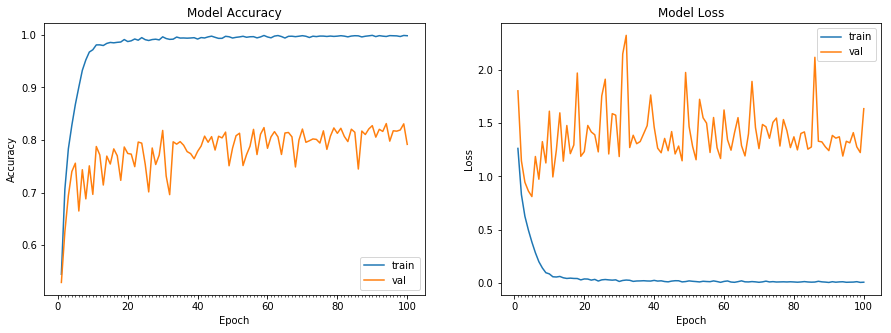

Accuracy on test data is: 79.17


In [16]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, shuffle=False,
                                 callbacks=[model_checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

# Loading the best trained model

In [0]:
model = load_model('drive/My Drive/EVA/S7/weights-improvement-90-0.83.hdf5', custom_objects={'tf': tf})

# Evaluating the model with the test data

In [27]:
model.evaluate(test_features, test_labels)

10000/10000 [==============================] - 13s 1ms/step


[1.241630284166336, 0.8273]